<h1 style="font-size:40px;"><center>EDAN95 - Applied Machine Learning<br> Lab 7: Deep Reinforcement Learning
</center></h1>

## Introduction
Reinforcement learning is the problem faced by an agent that learns behavior through trial-and-error interactions with a dynamic environment.

Reinforcement learning, one of the most active research areas in artificial intelligence, is a computational approach to learning whereby an agent tries to maximize the total amount of reward it receives while interacting with a complex, uncertain environment.

## Task Description
In this lab we are going to implement a deep reinforcement learning agent, a Vanilla Policy Gradient agent, that solves cartPole-v1. Then we need to try the agent on the harder problem of Lunar Lander-v2. Unlike in supervised learning, the algorithm does not learn from examples but rather from interacting with the problem, i.e. trial and error.

#### Environments
Our agent is going to solve the CartPole-v1 environment and then to experiment with applying the agent to the LunarLander-v2 environmen in OpenAI's Gym.

**Cart Pole**

 The goal of the environment is to balance a pole on top of a cart that your agent controls. The environment has four floats as the state: position, velocity, angle, and angular velocity. Your agent can either push the cart right or left.

From the OpenAI's webpage (https://gym.openai.com/envs/CartPole-v1/):

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

**Lunar Lander**

The second environment is the LunarLander-v2. Read more about it here https://gym.openai.com/envs/LunarLander-v2/.

## The experience replay module.
NOTE: When we use ReplayMemory class (in Geron) instead of a deque (ExpReplay class) it is much faster for random access.

In [1]:
from collections import deque

import numpy as np


class ExpReplay():
    """
    A generic class for collecting experiences.
    """

    def __init__(self, size):
        """
        Size is the maximum number of collected experiences.
        """
        self.memory = deque(maxlen=size)

    def add(self, exp):
        """
        Add an experience to the queue.
        """
        self.memory.append(exp)

    def sample(self, size):
        """
        Method to sample a collection experiences from the memory.
        Note that this is mostly used in off-policy methods such as Q-learning.
        """
        index = np.random.choice(np.arange(len(self.memory)),
                                 size=size,
                                 replace=False)
        return [self.memory[i] for i in index]

    def get_all(self):
        """Returns all collected experiences"""
        return list(self.memory)

    def clear(self):
        """Empty the memory."""
        self.memory.clear()
        

## Deep reinforcement learning.
We are going to implement the Vanilla Policy Gradient (also known as REINFORCE or Monte-Carlo Policy Gradient) algorithm for the agent. It's one of the most simple algorithms in deep reinforcement learning. Gradient Policy agents are at the heart of many of the latest breakthroughs such as OpenAI's Dota 2 agents.

The basic idea of the algorithm is to model the policy (the mapping from a state to an action) as a neural network. That is, the neural network takes the state as input and outputs a probability distribution over the possible actions. In this assignment we are going to use the SoftMax activation function to model the probability for each action. We then randomly sample an action based on the probability given by the SoftMax.

Vanilla Policy Gradient is an on-policy algorithm meaning we always follow the policy. This opposed to for example Q-learning where the agent would take the best action at each time step except with some small probability when it would instead take a random action to explore. In our algorithm, during training, the agent explores all the time since it samples from the policy distribution and does not only take the best (i.e. most probable action).

The agent's job is to find a policy $\pi$, mapping states to actions
that maximizes some long-run measure of reinforcement. The algorithm used by the software agent to determine its actions is called its **policy**. The policy, for example, could be a neural network taking observations as input and outputting the action to take. 

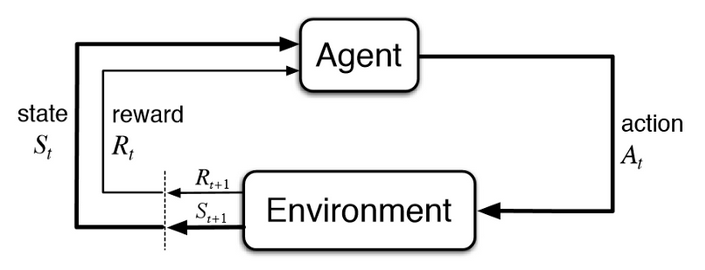

In [2]:
from IPython.display import Image, display; 
display(Image(filename='pic/sarsa.png'))

#### Policy search
There are many approaches of *policy search* like **brute force** approach and genetic algorithms to explore the policy space. Another approach is to use optimization techniques, by evaluating the gradients of the rewards with regards to the policy parameters, then tweaking these parameters by following the gradient toward higher rewards (gradient ascent). This approach is called *policy gradients* (PG). We will implement a popular PG algorithm using TensorFlow in the 2 different environments mentioned before, i.e. cart pole and lunar lander.

#### Environment OpenAI gym
training is	hard and slow in the real world, so	you	generally need a simulated environment at least	to bootstrap training. OpenAI gym is a toolkit that provides a wide variety of simulated environments so you can train agents, compare them, or develop new RL agorithms.

We expect in general that the environment will be non-deterministic; that is, that taking the same action in the same state on two different occasions may result in different next states and/or different reinforcement values. However, we assume the environment is stationary; that is that the probabilities of making state transitions or receiving specific reinforcement signals do not change over time.

Reinforcement learning differs from the more widely studied problem of supervised learning in several ways. The most important difference is that there is no presentation of input/output pairs. Instead after choosing an action the agent is told the immediate reward and the subsequent state but is not told which action would have been in its best long-term interests. It is necessary for the agent to gather useful experience about the possible system states,
actions, transitions and rewards actively to act optimally. Another difference from supervised learning is that on-line performance is important: the evaluation of the system is often concurrent with learning.

#### Neural Network Policies
Let's create a neural network that will take observations as inputs, and output the action to take for each observation. To choose an action, the network will first estimate a probability for each action, then select an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability p of the action 0 (left), and of course the probability of action 1 (right) will be 1 - p.

Here is	the	code to	build our neural network policy using TensorFlow:

Let’s go through this code:

1 - After the imports, we define the neural	network	architecture. The number of	inputs is the size of the	observation	space (which in	the	case of	the	CartPole is	four), we just have	four hidden	units and no need for more. For our problem, we actually need just one output probability (the probability of going left), but for using our model on the next environment as well, lunar lander, we choose two outputs (multi-class)

2 - Next we	build the neural network. In this example, it’s	a vanilla MLP (Multi-Layer Perceptron),	with a single output. Note that	for the	output layer it was enough to use the logistic (sigmoid) activation	function in	order to output	a probability from 0.0 to 1.0.	If there were more than	two	possible actions, there	would be one output	neuron per action, and you would use the softmax activation	function instead. Here we choose softmax for using this model also on the other environment. 

3 - Lastly,	we	call the multinomial() function	to pick	a random action. This function independently samples one or more integers, given the log probability of each integer. In our case, we just need one integer represeenting the action to take. Since the *outputs* tensor only contains the probability of going left, we must first concatenate *1-outputs* to it to have a tensor containing the probability of both left and right actions. Note that if there were more than two possible actions, the neural network would have to output one probability per action so you would not need the concatenation step. 

Here, we are picking a **random action** based on the probability given	by the neural network, rather than just picking	the	action with	the	highest	score. This approach lets the agent	find the right balance between **exploring** new actions and **exploiting**	the	actions that are known to work well. 

#### Training the network - The loss
We now have a neural network policy, in the code cell below, that will take observations and output actions. But how do we train it?

We don't have the label, so we use the reward R we get from using our policy, the sampled action, to compute the loss:
$$ loss = -R \log P(a) \quad \text{where} \quad R = r(s,a) $$


#### Policy Gradients
PG algorithms optimize the parameters of a policy by followingthe gradients toward higher rewards. One popular class of PG algorithms is called **Reinforce** algorithms.

Let’s implement	this algorithm	using TensorFlow. We will train	the	neural network policy we built earlier so that it learns to	balance	the	pole on	the	cart. Let’s	start by completing	the	construction phase we coded earlier	to add the target probability, the cost	function, and the training operation. Since	we are acting as though	the	chosen	action is the best possible	action,	the	target probability must	be 1.0 if the chosen action is action 0	(left) and 0.0 if it is action 1 (right).

Policy $pi$ is a distribution over actions given states
$$ \pi(a/s) = P(A_t = a / S_t = s) $$
Given that we are in state $s$ what action $a$ should we take ?

Policies define the **behaviour** of the agent.

Policies are **stationary**, they don't depend on time:
$$ \sum \pi (a/s) = 1 $$

#### Tensorflow Computation Graph
TensorFlow computations define a computation graph that has no numerical value until evaluated!

Thus, TensorFlow programs are usually structured into a **construction** phase, that assembles a graph, and an **execution** phase that uses a session to execute operations in the graph.

When we train a model we use variables to hold and update parameters. Variables are in-memory buffers
containing tensors. Calling sess.run(var) on a tf.Session() object retrieves its value. Can retrieve multiple variables simultaneously with sess.run([var1, var2])

## The entire deep reinforcement learning agent: agent.py - CartPole-v1 environment

In [2]:
from collections import deque

import tensorflow as tf
import numpy as np
from random import shuffle

#from .expreplay import ExpReplay


class Agent():
    """
    The agent class where you should implement the vanilla policy gradient agent.
    """
    
    def __init__(self, tf_session, state_size=(4,), action_size=2,
                 learning_rate=1e-3, gamma=0.99, memory_size=5000):
        """
        The initialization function. Besides saving attributes we also need
        to create the policy network in Tensorflow that later will be used.
        """
        # 1. Specify the network architecture
        self.state_size = state_size          # == env.observation_space.shape[0]
        self.n_outputs = action_size        # outputs the probability of accelerating left and right
        n_hidden = 5                          # it's a simple task, we don't need more than this
        n_inputs = 4
        
        # A Session object encapsulates the environment in which
        # Tensor objects are evaluated
        self.tf_sess = tf_session
        
        self.gamma = gamma
        self.replay = ExpReplay(memory_size)
        
        # variables initialization
        #initializer = tf.contrib.layers.variance_scaling_initializer()
        initializer = tf.variance_scaling_initializer()
        #initializer = tf.global_variables_initializer()


        # 2. Build the neural network
        with tf.variable_scope('agent'):
                       
            # Create tf.placeholder variables, i.e. inputs into the neural network graph.
            # tf.placeholder variables are dummy nodes that provide entry points 
            # for data to computational graph).
            self.X = tf.placeholder(tf.float32, shape=[None, n_inputs])
            
            self.reward = tf.placeholder(tf.float32, shape=(None,))
            
            self.action = tf.placeholder(tf.int32, shape=(None,))
            
            # Create the hidden layers
            hidden = tf.layers.dense(self.X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
            hidden2 = tf.layers.dense(hidden, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
            
            logits = tf.layers.dense(hidden2, self.n_outputs, activation=None)
            
            # create the output
            # use the SoftMax activation function to model the probability for each action
            self.outputs = tf.nn.softmax(logits)
            
            # 3. Select a random action based on the estimated probabilities. TO DO XXXX
            #self.action = tf.add(multinomial(tf.log(self.outputs), num_samples=2))   
            
            # define the cost function (cross entropy) and compute the gradients:
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.action, 
                                                                                      depth=self.n_outputs), 
                                                                    logits=logits)
            
            # Create the loss. We need to multiply the reward with the
            # log-probability of the selected actions.
            loss = tf.reduce_mean(self.reward * cross_entropy)

            # Create the optimizer to minimize the loss
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

            #pass

        # All variables are run after the model being fully constructed
        tf_session.run(tf.global_variables_initializer())
        #saver = tf.train.Saver()

    """
    take_action() that samples the action from the policy network. 
    Run the training and see that it works and acts randomly.
    """
    def take_action(self, state):
        """
        Given the current state, sample an action from the policy network.
        Return a the index of the action [0..N).
        """
        
        # A feed_dict is a python dictionary mapping from tf.placeholder variables 
        # (or their names) to data (numpy arrays, lists, etc.).
        
        # here use the SoftMax activation function to model the
        # probability for each action (outputs), see the network above
        action_pred = self.tf_sess.run(self.outputs, 
                                        feed_dict={self.X: [state]})[0]
        
        # We then randomly sample an action based on the estimated probability given by the SoftMax.
        action = np.random.choice(range(self.n_outputs), p=action_pred)
       
        #action = np.random.choice(range(self.action_size))
        return action

    """
    record_action() that just saves a taken action and its reward
    """
    def record_action(self, state0, action, reward, state1, done):
        """
        Record an action taken by the action and the associated reward
        and next state. This will later be used for traning.
        """
        self.replay.add((action, reward, state0))
        #self.replay.add((action, reward, state1))
        
        #pass

    """
    train_agent() that takes the experiences (states, actions, and rewards) 
    collected in record_action() and sends them through the network to compute 
    and optimize the loss.

    """
    def train_agent(self):
        """
        Train the policy network using the collected experiences during the
        episode(s).
        """
        # Retrieve collected experiences from memory
        collected_experiences = self.replay.get_all()
        
        # XXXX Refresh the memory
        self.replay.clear()                               
        
        actions = [h[0] for h in collected_experiences]
        rewards = [h[1] for h in collected_experiences]
        states = [h[2] for h in collected_experiences]

        # Discount and normalize rewards
        rewards = self.discount_rewards_and_normalize(rewards)

        # Shuffle for better learning
        # shuffle(collected_experiences)

        # Feed the experiences through the network with rewards to compute and
        # minimize the loss.
        # In tensorFlow, we supplement the values to placeholders using
        # a python dictionary feed_dict
        output = self.tf_sess.run(self.optimizer, 
                                  feed_dict={self.action: actions,
                                             self.reward: rewards, 
                                             self.X: states})
        #output = self.tf_sess.run(self.optimizer, 
         #                         feed_dict={self.reward: rewards})
        #pass

    """
    We need to compute the total discounted rewards,
    given the raw rewards, and to normalize the results across multiple episodes:
    """
    def discount_rewards(self, rewards, discount_rate):
        
        # Given the rewards for an epsiode discount them by gamma.
        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        
        for step in reversed(range(len(rewards))):
            cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
            discounted_rewards[step] = cumulative_rewards
        return discounted_rewards
    
    def discount_rewards_and_normalize(self, rewards):
        # Next since we are sending them into the neural network they should
        # have a zero mean and unit variance.
        dis_rewards = self.discount_rewards(rewards, self.gamma)
        
        reward_mean = dis_rewards.mean()
        reward_std = dis_rewards.std()
        
        # Return the new discounted and normalized rewards.
        return (dis_rewards - reward_mean)/ reward_std 
        #return ((dis_rewards - reward_mean)/reward_std) 
        
        # pass

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Main - The entrypoint of the program with the training loop (main.py) - CartPole-v1


In [4]:
from time import time

import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#from .agent import Agent


def env_solved(history):
    """
    Checks if the agent has solved the CartPole-v1 environment.
    """
    return history[-1]['mean_reward'] >= 450


def main(nbr_eps, tf_session, render_every=100):
    """Main training loop of the RL agent."""

    # Create the environment
    env = gym.make('CartPole-v1')
    env.seed(1)

    # Create the agent
    agent = Agent(tf_session,
                  state_size=env.observation_space.shape,
                  action_size=env.action_space.n,
                  learning_rate=1e-2,
                  gamma=0.99)
    
    history = []
    
    
    ####  Evaluating the performance ot our agent
    for episode in range(1, nbr_eps + 1):
        
        # Start an episode of training
        # After the environment is created, 
        # we must initialize it using the reset() method
        state0 = env.reset()
        
        # done: This value will be True when the episode is over.
        done = False
        step = 0
        total_reward = 0
        tt = time()

        # Take actions until the end of the episode
        while not done:

            # Render every nth episode
            # the render() method displays the environment
            if episode % render_every == 0:
                env.render()

            # Ask agent for action
            action = agent.take_action(state0)

            # Apply action to the environment. Get reward and the new state.
            state1, reward, done, _ = env.step(action)

            # Memorizing: Record the <s, a, r, s'> tuple for later when training.
            agent.record_action(state0, action, reward, state1, done)

            total_reward += reward
            step += 1
            state0 = state1

        
        # Train the network after each episode
        agent.train_agent()

        # Save information about the episode
        mean_reward = np.mean(np.array([h['reward'] for h in history[-100:]])) \
            if len(history) > 0 else 0
        
        history.append({
            'episode': episode, 'reward': total_reward, 'steps': step, 'time': time() - tt,
            'mean_reward': mean_reward
        })
        
        # Print information about the episode
        print('Information about the episode: \n', 
              episode, total_reward, step, "%.2f" % mean_reward)

        if env_solved(history):
            print('Agent solved the environment in {} episodes!'.format(episode))
            plt.plot([h['mean_reward'] for h in history])
            plt.ylabel('Mean reward')
            plt.xlabel('Episode')
            plt.show()
            break


if __name__ == '__main__':
    tf.reset_default_graph()
    with tf.Session() as tf_session:
        main(3000, tf_session)
        

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Information about the episode: 
 1 14.0 14 0.00
Information about the episode: 
 2 21.0 21 14.00
Information about the episode: 
 3 18.0 18 17.50
Information about the episode: 
 4 9.0 9 17.67
Information about the episode: 
 5 46.0 46 15.50
Information about the episode: 
 6 12.0 12 21.60
Information about the episode: 
 7 24.0 24 20.00
Information about the episode: 
 8 8.0 8 20.57
Information about the episode: 
 9 12.0 12 19.00
Information about the episode: 
 10 18.0 18 18.22
Information about the episode: 
 11 50.0 50 18.20
Information about the episode: 
 12 57.0 57 21.09
Information about the episode: 
 13 20.0 20 24.08
Information about the episode: 
 14 103.0 103 23.77
Information about the episode: 
 15 41.0 41 29.43
Information about the episode: 
 16 49.0 49 30.20
Information about th

Information about the episode: 
 155 186.0 186 97.80
Information about the episode: 
 156 104.0 104 99.18
Information about the episode: 
 157 105.0 105 99.85
Information about the episode: 
 158 207.0 207 100.71
Information about the episode: 
 159 141.0 141 102.41
Information about the episode: 
 160 159.0 159 103.41
Information about the episode: 
 161 168.0 168 104.81
Information about the episode: 
 162 198.0 198 105.75
Information about the episode: 
 163 325.0 325 106.95
Information about the episode: 
 164 451.0 451 109.79
Information about the episode: 
 165 330.0 330 114.03
Information about the episode: 
 166 145.0 145 116.93
Information about the episode: 
 167 500.0 500 117.97
Information about the episode: 
 168 500.0 500 121.77
Information about the episode: 
 169 173.0 173 126.45
Information about the episode: 
 170 92.0 92 127.85
Information about the episode: 
 171 210.0 210 128.09
Information about the episode: 
 172 390.0 390 129.57
Information about the episode: 
 

Information about the episode: 
 307 167.0 167 390.32
Information about the episode: 
 308 219.0 219 389.25
Information about the episode: 
 309 193.0 193 388.70
Information about the episode: 
 310 186.0 186 389.43
Information about the episode: 
 311 208.0 208 388.55
Information about the episode: 
 312 189.0 189 389.06
Information about the episode: 
 313 207.0 207 389.32
Information about the episode: 
 314 158.0 158 388.48
Information about the episode: 
 315 178.0 178 388.89
Information about the episode: 
 316 167.0 167 389.30
Information about the episode: 
 317 149.0 149 389.57
Information about the episode: 
 318 199.0 199 390.24
Information about the episode: 
 319 194.0 194 390.63
Information about the episode: 
 320 193.0 193 389.74
Information about the episode: 
 321 149.0 149 390.06
Information about the episode: 
 322 165.0 165 388.72
Information about the episode: 
 323 162.0 162 385.78
Information about the episode: 
 324 171.0 171 386.23
Information about the episod

Information about the episode: 
 459 413.0 413 363.61
Information about the episode: 
 460 440.0 440 366.27
Information about the episode: 
 461 348.0 348 369.20
Information about the episode: 
 462 376.0 376 371.23
Information about the episode: 
 463 333.0 333 372.95
Information about the episode: 
 464 329.0 329 374.99
Information about the episode: 
 465 334.0 334 376.70
Information about the episode: 
 466 342.0 342 377.92
Information about the episode: 
 467 440.0 440 379.82
Information about the episode: 
 468 341.0 341 382.45
Information about the episode: 
 469 439.0 439 383.94
Information about the episode: 
 470 408.0 408 386.63
Information about the episode: 
 471 499.0 499 389.11
Information about the episode: 
 472 460.0 460 391.72
Information about the episode: 
 473 500.0 500 394.19
Information about the episode: 
 474 500.0 500 397.27
Information about the episode: 
 475 500.0 500 400.73
Information about the episode: 
 476 500.0 500 403.45
Information about the episod

<Figure size 640x480 with 1 Axes>

## References
L. P. Kaelbling, M. L. Littman, and A. W. Moore. Reinforcement learning:
A survey. Journal of Artificial Intelligence Research, 4:237–285, 1996.

T. M. Mitchell. Machine Learning. McGraw Hill, 1997.

R. Sutton and A. Barto. Reinforcement Learning. MIT Press, 1999. Also available online at
http://www-anw.cs.umass.edu/~rich/book/the-book.html